In [11]:
import numpy as np
from typing import Tuple


def sig1(n1: float, n2: float) -> np.ndarray:
    return np.sin(2 * np.pi * n1 + 3 * np.pi * n2)


def sig2(n1: float, n2: float) -> np.ndarray:
    return np.sin(4 * np.pi * n1) + np.cos(6 * np.pi * n2)


def pixels(width: int, height: int) -> Tuple[np.ndarray, np.ndarray]:
    h_points = np.arange(width)
    v_points = np.arange(height)

    h_coord = np.tile(h_points, (height, 1))
    v_coord = np.tile(np.expand_dims(v_points, axis=0).T, (1, width))

    return h_coord, v_coord


def time1(width: int, height: int) -> np.ndarray:
    h, v = pixels(width, height)
    return sig1(h, v)


def time2(width: int, height: int) -> np.ndarray:
    h, v = pixels(width, height)
    return sig2(h, v)


def freq1(width: int, height: int) -> np.ndarray:
    if min(width, height) < 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[0][5] = Y[0][width - 5] = 1.0
    return Y


def freq2(width: int, height: int) -> np.ndarray:
    if min(width, height) < 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[5][0] = Y[height - 5][0] = 1.0
    return Y


def freq3(width: int, height: int) -> np.ndarray:
    if min(width, height) < 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[5][5] = Y[width - 5][height - 5] = 1.0
    return Y


In [17]:
def freq_to_time(freq: np.ndarray) -> np.ndarray:
    return np.real(np.fft.ifft2(freq))


def time_to_freq(time: np.ndarray) -> np.ndarray:
    return np.fft.fft2(time)


In [19]:
N = 256
width, height = N, N

t1 = time1(width, height)
t2 = time2(width, height)
t3 = None
t4 = None
t5 = None

f1 = None
f2 = None
f3 = freq1(width, height)
f4 = freq2(width, height)
f5 = freq3(width, height)

f1 = time_to_freq(t1)
f2 = time_to_freq(t2)
t3 = freq_to_time(f3)
t4 = freq_to_time(f4)
t5 = freq_to_time(f5)

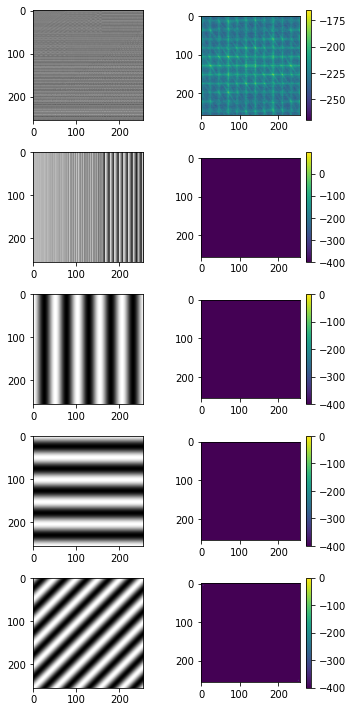

In [22]:
import matplotlib.pyplot as plt

inputs = [
    (t1, f1),
    (t2, f2),
    (t3, f3),
    (t4, f4),
    (t5, f5),
]

fig, axis = plt.subplots(len(inputs), len(inputs[0]), figsize=(5, 10))
fig.tight_layout()

for i, (time, freq) in enumerate(inputs):
    im_time = axis[i][0].imshow(time, cmap='gray')
    im_freq = axis[i][1].imshow(20 * np.log10(np.abs(freq) + 1e-20))
    fig.colorbar(im_freq, ax=axis[i][1])


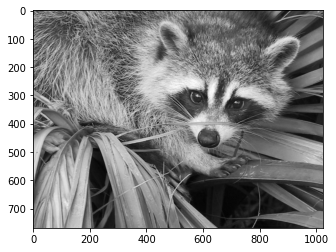

In [229]:
from scipy import misc, ndimage

X = misc.face(gray=True)
plt.imshow(X, cmap=plt.cm.gray)
plt.show()